In this notebook we make the target selection figure for AFKABAN


In [1]:
import time
import os.path
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cm import ScalarMappable
import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import AnchoredText
from sklearn import preprocessing
import seaborn as sns
from datetime import timedelta, datetime
from tenacity import retry, stop_after_attempt
import glob
import scipy as sc
import csaps
import echoregions as er
import echopype as ep

import sys, errno  


In [2]:

palette = sns.color_palette()
plt.style.use(['seaborn-colorblind'])
plt.rc('font', family='Arial')
SMALL_SIZE = 11
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.direction'] = 'inout'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 1

savefigs_path = 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AFKABAN'
one_col = 85 *0.0393701
two_col = 170*0.0393701

In [3]:
# -- USER-DETERMINED PARAMETERS -----------------------------------------------
letter_drive = 'F'
ppath = f'{letter_drive}:/AFKABAN/Pcod_190123/select/'
p2path = f'{letter_drive}:/AFKABAN/Pcod2_240123/select/'
apath = f'{letter_drive}:/AFKABAN/Acod_200123/select/'
pbpath = f'{letter_drive}:/AFKABAN/Pandalus_260123/select/'


In [5]:
a_tilt_df = pd.read_feather(f'{apath}/a_tilt_df.feather')
p_tilt_df = pd.read_feather(f'{ppath}/p_tilt_df.feather')
p2_tilt_df = pd.read_feather(f'{p2path}/p2_tilt_df.feather')
pb_tilt_df = pd.read_feather(f'{pbpath}/pb_tilt_df.feather')


# Plot all tracks

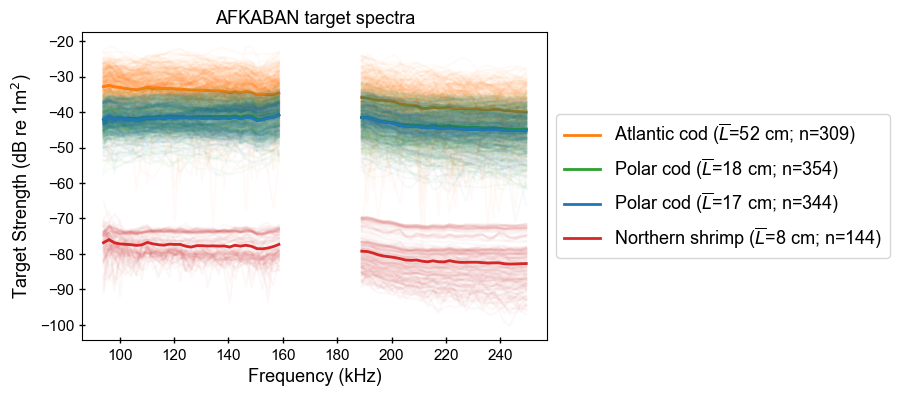

In [6]:
df_list = [a_tilt_df,p_tilt_df,p2_tilt_df,pb_tilt_df]
name_list = ['Atlantic cod ($\overline{L}$=52 cm;', 'Polar cod ($\overline{L}$=18 cm;', 'Polar cod ($\overline{L}$=17 cm;', 'Northern shrimp ($\overline{L}$=8 cm;']
fig,ax = plt.subplots(1,1, figsize=(6,4))
c_list=[1,2,0,3]
for i_df in range(len(df_list)):
    # calculate median tilt for intervals of 10 degrees tilt
    df = df_list[i_df]
    
    ts_s = np.where(df.columns.values=='90.000')[0][0]
    ts_e = np.where(df.columns.values=='255.565')[0][0]

    df_ts = df.iloc[:,ts_s:ts_e+1]
    # remove spectra with poor calibration results removed 161-170 kHz
    
    freqs = df_ts.columns.unique().values.astype(np.float64)
    # Plot median and CI
    ax.plot(freqs,df_ts.mean(), c=palette[c_list[i_df]], linewidth = 2, label='%s n=%.0f)'%(name_list[i_df],(len(df_ts)/2)))
    ax.plot(freqs,df_ts.T, c = palette[c_list[i_df]], alpha=0.03)

    
    ax.set_ylabel('Target Strength (dB re 1m$^2$)', fontsize=13)
    ax.set_title('AFKABAN target spectra', fontsize=13)
    ax.set_xlabel('Frequency (kHz)', fontsize=13)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=13)
    
fig.savefig('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AFKABAN/TargetSpectra.jpeg', format='jpeg', dpi = 300, facecolor='w', bbox_inches='tight', transparent=True)

Observations:
- It seems that a threshold at -60 dB could be used to discriminate between Northen shrimp and polar or Atlantic cod. 
- High variability in broadband target spectra, largest for Atlantic cod (~10 dB)
- Both Polar cod medians follow same pattern. Atlantic cod is very similar but slight differences

# Select track

In [7]:
a_ts = pd.read_csv('F:/AFKABAN/Acod_200123/Region94_TS.ts.csv',header=None, skiprows=1,index_col = 0)
p_ts = pd.read_csv('F:/AFKABAN/Pcod_190123/Region169_TS.ts.csv',header=None, skiprows=1,index_col = 0)
pb_ts = pd.read_csv('F:/AFKABAN/Pandalus_260123/Region305_TS.ts.csv',header=None, skiprows=1,index_col = 0)
time_cols = [3,4]

In [8]:
a_track = 'Region 94'
p_track = 'Region 164'
pb_track = 'Region 305'

In [9]:
start = 150
n_bins = np.shape(a_ts)[1]-start
TS_cols = np.arange(start,n_bins+start)

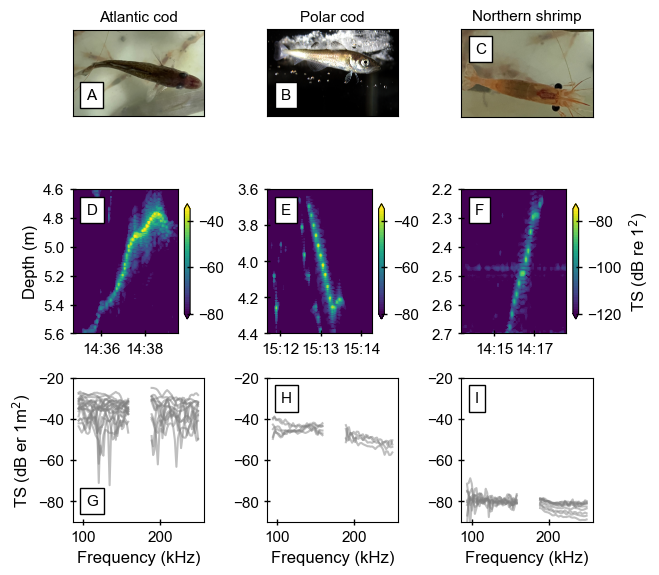

In [12]:
track_list = [a_track, p_track, pb_track]
df_list = [a_tilt_df, p_tilt_df, pb_tilt_df]
ts_list = [a_ts, p_ts, pb_ts]

im_path = glob.glob("C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AFKABAN")

heights = [1, 2, 2]
fig, axes = plt.subplots(3,3, figsize=(two_col,6))



### -------------- Photo panel----------------

im_0 = plt.imread(im_path[0]+'\AtlanticCodphoto.jpg')
axes[0,0].imshow(im_0)
at = AnchoredText('A', loc='lower left')
axes[0,0].add_artist(at)
axes[0,0].set(xticks=[], yticks=[])
axes[0,0].set_title('Atlantic cod')

im_1 = plt.imread(im_path[0]+'\Polardorsch1_HFlores.jpg')
axes[0,1].imshow(im_1)
at = AnchoredText('B', loc='lower left')
axes[0,1].add_artist(at)
axes[0,1].set(xticks=[], yticks=[])
axes[0,1].set_title('Polar cod')

im_2 = plt.imread(im_path[0]+'\Pandalusphoto.jpg')
axes[0,2].imshow(im_2)
at = AnchoredText('C', loc='upper left')
axes[0,2].add_artist(at)
axes[0,2].set(xticks=[], yticks=[])
axes[0,2].set_title('Northern shrimp')



# ------------------ Backscatter panel------------

for panel_i in range(0,3):
    ts_df = ts_list[panel_i]
    letter = ['D','E','F']
    # Set up contour data
    depth = ts_df.iloc[0,7:9]
    start_range = depth[8]
    end_range = depth[9]
    d_range = np.linspace(start_range, end_range,n_bins)
    TS_data = ts_df.iloc[:,TS_cols]
    TS_data_thres = np.where(TS_data<-999,np.nan,TS_data) # Change -999 to NaN
    times = []
    for ind in range(0,len(ts_df)):
        times = np.append(times, datetime.strptime('%s %s' %(ts_df[3].values[ind],ts_df[4].values[ind]), '%Y-%m-%d %H:%M:%S'))

    # Colourbar levels
    if panel_i == 2:
        levels=np.linspace(-120,-75,46)
    else:
        levels=np.linspace(-80,-35,46)
        
    
    cs = axes[1,panel_i].contourf(times, d_range+1, TS_data_thres.T, cmap='viridis', extend="both", levels=levels)
    
    # Add panel letter
    at = AnchoredText(letter[panel_i], loc='upper left')
    axes[1,panel_i].add_artist(at)
    
    # Adjust date axis
    fmt = mdates.DateFormatter('%H:%M')
    axes[1,panel_i].xaxis.set_major_formatter(fmt)
    axes[1,panel_i].xaxis.set_major_locator(plt.MaxNLocator(3))
    axes[1,panel_i].yaxis.set_major_locator(plt.MaxNLocator(5))

    if panel_i == 2:
        fig.colorbar(cs, ax=axes[1,panel_i], shrink=0.8, ticks=range(int(levels[0]), int(levels[-1]), 20), label='TS (dB re 1$^2$)')
    else:
        fig.colorbar(cs, ax=axes[1,panel_i], shrink=0.8, ticks=range(int(levels[0]), int(levels[-1]), 20))
                 
# set limits on echogram to zoom on track
axes[1,0].set_ylim([5.6,4.6])
axes[1,0].set_xlim([datetime(2023,1,20,14,36,0),datetime(2023,1,20,14,39,30)])
axes[1,1].set_ylim([4.4,3.6])
axes[1,1].set_xlim([datetime(2023,1,19,15,12,0),datetime(2023,1,19,15,15,0)])
axes[1,2].set_ylim([2.7,2.2])
axes[1,2].set_xlim([datetime(2023,1,26,14,15,0),datetime(2023,1,26,14,18,0)])



# ------------------ Target Spectra panel------------

for panel_i in range(0,3):
    track = track_list[panel_i]
    df = df_list[panel_i]
    select_track = df[df['Region_name']==track]

    ts_s = np.where(select_track.columns.values=='90.000')[0][0]
    ts_e = np.where(select_track.columns.values=='255.565')[0][0]

    freqs = select_track.columns.unique()[ts_s:ts_e].values.astype(np.float64)
    axes[2,panel_i].plot(freqs,select_track.iloc[:,ts_s:ts_e].T, 'grey', alpha=0.5);
    #axes[2,panel_i].plot(freqs,np.nanmedian(select_track.iloc[:,ts_s:ts_e].T,axis=1), 'k')
    #axes[2,panel_i].set(title=track, xlabel='Frequency (kHz)')
    axes[2,panel_i].set_ylim([-90,-20])
    axes[2,panel_i].set_xlabel('Frequency (kHz)')
    
# Add panel letter
at = AnchoredText('G', loc='lower left')
axes[2,0].add_artist(at)

at = AnchoredText('H', loc='upper left')
axes[2,1].add_artist(at)

at = AnchoredText('I', loc='upper left')
axes[2,2].add_artist(at)

axes[2,0].set_ylabel('TS (dB er 1m$^{2}$)');
axes[1,0].set_ylabel('Depth (m)');
fig.tight_layout()
fig.savefig('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AFKABAN/SpeciesPanels.jpeg', format='jpeg', dpi = 300, facecolor='w', bbox_inches='tight', transparent=True)
#fig.savefig('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/PhDdocs/ConferencesMeetings/CMOS2023/SpeciesPanels.jpeg', format='jpeg', dpi = 300, facecolor='w', bbox_inches='tight', transparent=True)

### number of SED in tracks for each bandwidth

In [11]:
species_list = ['Atlantic cod', 'Polar cod', 'Northern shrimp']

In [ ]:
for panel_i in range(0,3):
    track = track_list[panel_i]
    df = df_list[panel_i]
    select_track = df[df['Region_name']==track]
    species = species_list[panel_i]

    ts_s = np.where(select_track.columns.values=='98.065')[0][0]
    ts_e = np.where(select_track.columns.values=='191.048')[0][0]
    
    n_120 = np.sum(~np.isnan(select_track.iloc[:,ts_s]))
    n_200 = np.sum(~np.isnan(select_track.iloc[:,ts_e]))
    
    print(f'{species}: There are {n_120} SED in the 120 kHz bandwidth and {n_200} SED in the 200 kHz bandwidth')